In [1]:
%pylab inline
import pandas as pd
import IGtools as igt
import networkx as nx
import os, sys 
import matplotlib.pyplot as plt
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import igraph as ig

In [3]:
plt.style.use('fivethirtyeight')
def plot_results(x,data,norm=None,label=None,marker='s'):
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.gca()
    if norm==None:
        plt.errorbar(x, np.array(yy), np.array(std_yy), fmt=marker,ms=10,alpha=0.6, label=label);
    else:
        plt.errorbar(x, np.array(yy)/float(norm), np.array(std_yy)/float(norm), fmt=marker,ms=10,alpha=0.6, label=label);
    return;

In [26]:
from scipy.optimize import fsolve, fmin, root

def attempt_scipy_func(x, d, c):
    Lam = 1/float(d);
    return np.abs(x - np.power(1 - (Lam*Lam)/float(x*(Lam - np.log(x))*(Lam - np.log(x))), c-1));


def minimize_exp_pstar(xs, d, c):
    vals = map(lambda x: attempt_scipy_func(x, d, c), xs);
    x0 = (np.min(vals), xs[np.nanargmin(vals)])
    return x0[1]

def rho_exp(pstar,Lam,c):
    d = 1/float(Lam);
    ed01dp0 = ( Lam - Lam**Lam + Lam*np.log(pstar) ) / float( (Lam-np.log(pstar))**2 )
    return (d/c)  * (1 - np.power(pstar,c/float(c-1))) + (ed01dp0);

def expo_prediction(average_k,xs=None,c=2):
    if xs == None:
        xs = np.linspace(0,1,1000);
    import time 
    now = time.time()
    rho_stars_exp = []
    for i,d in enumerate(average_k):
        p_stars_exp = minimize_exp_pstar(xs, 1/float(d), c);
        rho_stars_exp.append(rho_exp(p_stars_exp, 1/float(d), c));
    return rho_stars_exp;

In [38]:
num_iter = 10;
N = 100;
k_min = 0.1
k_max = 25
ps = np.linspace(k_min,k_max,50);


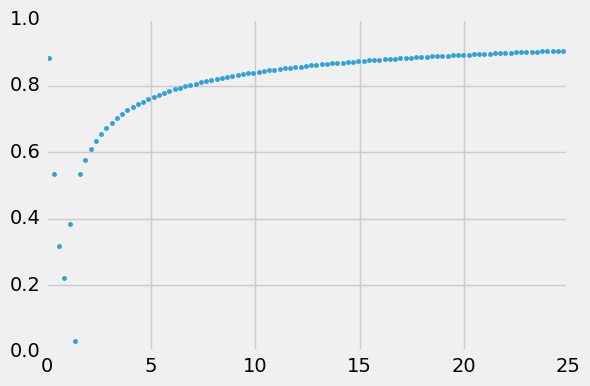

In [39]:
c = 2
pss = np.linspace(ps[0],ps[-1],100)
xs = np.linspace(0,1,5000);
plt.plot(pss, map(lambda x: minimize_exp_pstar(xs, 1/float(x), c), pss),'.')
plt.legend(loc=0)

(0, 5)

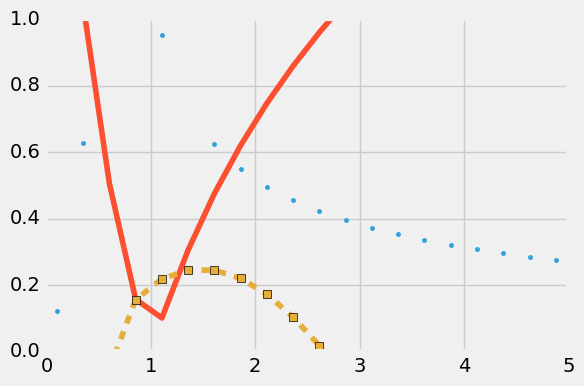

In [40]:
c = 2
pss = np.linspace(ps[0],ps[-1],100)
xs = np.linspace(0,1,5000);
plt.plot(pss, np.abs(np.log(map(lambda x: minimize_exp_pstar(xs, 1/float(x), c), pss))),'.')
plt.plot(pss, np.abs(np.log(1/pss)))
plt.legend(loc=0)
plt.plot(pss, expo_prediction(pss),'--s', label=r'exponential')
plt.ylim(0,1)
plt.xlim(0,5)

(0, 1)

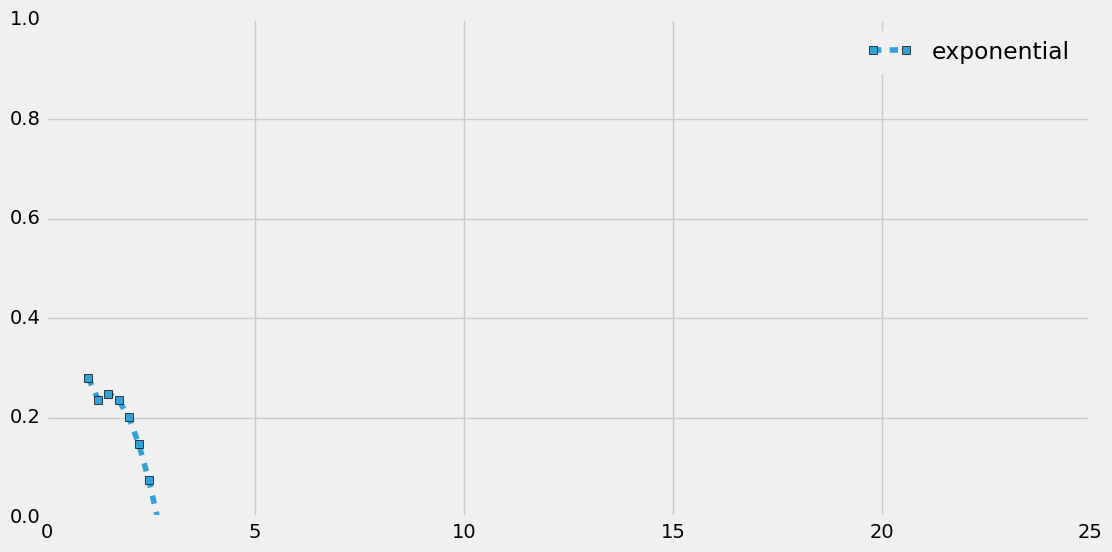

In [29]:
pss = np.linspace(k_min,k_max,100)
fig = plt.figure(figsize=(12,6))
plt.plot(pss, expo_prediction(pss),'--s', label=r'exponential')
plt.legend(loc=0)
plt.ylim(0,1)

In [ ]:
N = 100
k_min = 1
k_max = 50
pmin = k_min/float(N);
pmax = k_max/float(N);
psp = range(k_min,k_max,1);

In [ ]:
import sympy as sy
def p_star(d,c):
    x = sy.Symbol('x')
    return sy.solve(x - sy.Pow((1-sy.exp(d*(x-1))), c-1), x)
def rho(d,c,p_star):
    return (d/float(c)) * (1-np.power(float(p_star),(c/float(c-1)))) + (1-float(p_star)*d)*np.exp(d*(float(p_star)-1));

x_p = range(0,11);
p_stars = []
for l in x_p:
    p_stars.append(sy.N(p_star(l,2)[0]));

rhos = []
for i,s in enumerate(x_p):
    rhos.append( rho(s,2,p_stars[i]) )

In [ ]:
sigmas = {}
pss = np.linspace(k_min,k_max,100)
fig = plt.figure(figsize=(12,6))
sigmas = map(lambda x: pss[0]/float(x), pss);
plt.plot(pss, gaussian_prediction(pss, sigmas),'--s')
plt.legend(loc=0)

x_p = range(k_min,k_max,1);
p_stars = []
for l in x_p:
    p_stars.append(sy.N(p_star(l,2)[0]));

rhos = []
for i,s in enumerate(x_p):
    rhos.append( rho(s,2,p_stars[i]) )
plt.plot(x_p,rhos,'-')
plt.xlim(0,20)

# Comparison with simulations

In [ ]:
num_iter = 10;
N = 50;

res_ig = {};
res_ig_fg = {}
res_ig_fg_v1 = {}
res_ig_fg_v2 = {}
res_ig_fg_clique = {}
res_leaf_branch = {}
res_leaf_core = {}
av_k_ig = {}
n_ig_dict = {}
import time
from datetime import datetime

import igraph as igg
#k_min = 0.5
#k_max = 15
#pmin = k_min/float(N);
#pmax = k_max/float(N);
precision = 30
#ps = np.linspace(pmin,pmax,precision);

from scipy.stats import norm
#rvs(loc=0, scale=1, size=1, random_state=None)
xs = np.linspace(0,1,2000)

for n_sigma in n_sigmas:
    print n_sigma;
    res_ig[n_sigma] = {};
    av_k_ig[n_sigma] = {};
    n_ig_dict[n_sigma] = {};

    for l,p in enumerate(pss[:40]):
        print l, '/', precision, ':', p, 'started:', str(datetime.now())

        res_ig[n_sigma][p] = []
        av_k_ig[n_sigma][p] = [];
        n_ig_dict[n_sigma][p] = []
        for it in range(num_iter):
            deg = map(lambda x: np.max([0, int(x)]), norm.rvs(p,n_sigma*np.sqrt(p),N));
            if not np.sum(deg)%2==0:
                deg[0]+=1;
            g = nx.configuration_model(deg)
            av_k_ig[n_sigma][p].append(np.mean(g.degree().values()));
            n_g = g.number_of_nodes()
            n_ig_dict[n_sigma][p].append(n_g);
            nx.write_gml(g,'test.gml');
            g_igraph = igg.load('test.gml')
            res_ig[n_sigma][p].append( g_igraph.alpha() / float(n_ig) )  


In [ ]:
plt.style.use('fivethirtyeight')
def plot_results(x,data,norm=None,label=None,marker='s'):
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.gca()
    if norm==None:
        plt.errorbar(x, np.array(yy), np.array(std_yy), fmt=marker,ms=10,alpha=0.6, label=label);
    else:
        plt.errorbar(x, np.array(yy)/float(norm), np.array(std_yy)/float(norm), fmt=marker,ms=10,alpha=0.6, label=label);
    return;

In [ ]:
res_ig[n_sigma][p]

In [ ]:
n_sigmas = np.linspace(0,2,11)#range(1,5);
sigmas = {}
pss = np.linspace(k_min,k_max,100)
fig = plt.figure(figsize=(20,20))
for i, n_sigma in enumerate(n_sigmas):
    plt.subplot(4,3,i+1)
    print n_sigma
    sigmas = map(lambda x: n_sigma*np.sqrt(x), pss);
    plot_results(pss[:40], res_ig[n_sigma],norm=1)
    plt.plot(pss, gaussian_prediction(pss, sigmas),'--k', label=r'$\sigma^2 =$'+str(n_sigma)+r'$\mu$')
    plt.legend(loc=0)

    x_p = range(k_min,k_max,1);
    plt.plot(x_p,rhos,'-r')
    plt.xlim(0,20)

# Simulation-driven comparison with IG 

In [ ]:
num_iter = 10;
nN = 20;

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_gauss_pred = {}

import time
from datetime import datetime

import igraph as igg
new_k_min = 1
new_k_max = 15
new_pmin = new_k_min/float(nN);
new_pmax = new_k_max/float(nN);
precision = 30
new_ps = np.linspace(new_pmin,new_pmax,precision);

from scipy.stats import norm
#rvs(loc=0, scale=1, size=1, random_state=None)

for l,p in enumerate(new_ps):
    print l, '/', precision, ':', p, 'started:', str(datetime.now())
    new_gauss_pred[p] = []
    new_res_ig[p] = []
    new_av_k_ig[p] = [];
    new_n_ig_dict[p] = []
    for it in range(num_iter):
        g = igt.create_ER_bipartite_graph(nN,p)
        lg = igt.line_graph(g)
        ig = igt.interference_graph(lg)
        new_av_k_ig[p].append(np.mean(ig.degree().values()));
        new_n_ig = ig.number_of_nodes()
        new_n_ig_dict[p].append(new_n_ig);
        nx.write_gml(ig,'test.gml');
        g_igraph = igg.load('test.gml')
        new_res_ig[p].append( g_igraph.alpha() )    
        mu = np.mean(g.degree().values());
        sigma =  np.std(g.degree().values());
        p_stars_gauss = minimize_gauss_pstar(xs,mu,sigma**2, 2);
        new_gauss_pred[p].append(rho_gauss(p_stars_gauss, mu , sigma**2,2));

In [ ]:
fig = plt.figure(figsize=(12,6))
plot_results(new_ps,new_gauss_pred,norm=1, label='Replica Symmetry prediction')
plot_results(new_ps,new_res_ig,norm=nN,label='Simulations')
plt.title('MIS density for IG of an ER-based bipartite graph')
plt.legend(loc=0)

In [ ]:
new_x_p = map(lambda x: int(np.mean(new_av_k_ig[x])), new_ps)
new_p_stars = []
for l in new_x_p:
    new_p_stars.append(sy.N(p_star(l,2)[0]));

new_rhos = []
for i,s in enumerate(new_x_p):
    new_rhos.append( rho(s,2,new_p_stars[i]) )
plt.plot(new_x_p,new_rhos,'-')

In [ ]:
for p in new_res_ig.keys():
    plt.plot()

In [ ]:
num_iter = 15;
N = 20;

import time
from datetime import datetime

k_min = 2
k_max = 15
pmin = k_min/float(N);
pmax = k_max/float(N);
precision = 30
ps = range(2,15)

res_ig_bg = {};
av_deg_ig= {}
n_ig = {}
std_deg_ig = {}
gaussian_predictions = {}

for l,p in enumerate(ps):
    print l, '/', precision, ':', p, 'started:', str(datetime.now())
    res_ig_bg[p] = []
    av_deg_ig[p] = []
    std_deg_ig[p] = []
    n_ig[p] = []
    for it in range(num_iter):
        degree_seq = nx.erdos_renyi_graph(N,p/float(N-1)).degree().values();
        if np.sum(degree_seq)%2!=0:
            degree_seq[0]+=1;
        g = igt.create_configuration_model_graph(degree_seq);
        lg = igt.line_graph(g);
        igg = igt.interference_graph(lg);
        n_ig[p].append(igg.number_of_nodes())
        av_deg_ig[p].append(np.mean(igg.degree().values()))
        std_deg_ig[p].append(np.std(igg.degree().values()))
        nx.write_gml(igg,'test.gml');
        g_igraph = ig.load('test.gml')
        res_ig_bg[p].append( g_igraph.alpha() )


In [ ]:
gaussian_predictions = {}
poissonian_predictions = {}
for p in ps:
    gaussian_predictions[p] = gaussian_prediction(av_deg_ig[p], std_deg_ig[p])

x_p = range(k_min,k_max,1);
p_stars = []
for l in x_p:
    p_stars.append(sy.N(p_star(l,2)[0]));

rhos = []
for i,s in enumerate(x_p):
    rhos.append( rho(s,2,p_stars[i]) )
plt.plot(x_p,rhos,'-')

In [ ]:
plot_results(ps*N,res_ig_bg,norm=N,label='IG Graph MIS',marker='o-')
plot_results(ps*N,gaussian_predictions,norm=1,label='IG prediction MIS',marker='o-')
plt.plot(x_p, rhos,label='poisson')
plt.legend(loc=0)

In [ ]:
for p in av_deg_ig.keys():
    plt.loglog(p, np.mean(np.array(std_deg_ig[p])/np.array(av_deg_ig[p])),'o')
    
y = map(lambda x: np.mean(np.array(std_deg_ig[x])/np.array(av_deg_ig[x])), av_deg_ig.keys())
fit = np.polyfit(np.log(av_deg_ig.keys()), np.log(y))
print fit

In [ ]:
n_sigmas = range(1,6);
sigmas = {}

fig = plt.figure(figsize=(12,10))
for n_sigma in n_sigmas:
    print n_sigma
    sigmas = map(lambda x: n_sigma * np.sqrt(x), pss);
    plt.plot(pss, gaussian_prediction(pss, sigmas),'--s', label=str(n_sigma))
plt.legend(loc=0)

plt.plot(psp,rhos,'-')

plot_results(ps,res_ig_reg,norm=50,label='RR Graph MIS',marker='o-')
plot_results(ps,res_ig_poiss,norm=50,label='Poisson Graph MIS',marker='o')
plot_results(pgs,res_ig_gauss_sigma[1],norm=50,label='Gauss small Graph MIS',marker='-o')
plot_results(pgs,res_ig_gauss_sigma[2],norm=50,label='Gauss medium Graph MIS',marker='-o')
plot_results(pgs,res_ig_gauss_sigma[3],norm=50,label='Gauss large Graph MIS',marker='-o')
plt.legend(loc=0)

In [ ]:
k_min = 1
k_max = 25
pmin = k_min/float(N);
pmax = k_max/float(N);
ps = range(k_min,k_max);

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.subplot(111)
x = ps
N=50
#plot_results(x,res_ig_er,norm=N,label='ER Graph MIS',marker='o')
plot_results(x,res_ig_reg,norm=N,label='RR Graph MIS',marker='o-')
plot_results(x,res_ig_poiss,norm=N,label='Poisson Graph MIS',marker='o')
plot_results(x,res_ig_gauss_small,norm=N,label='Gauss small Graph MIS',marker='-o')
plot_results(x,res_ig_gauss_medium,norm=N,label='Gauss medium Graph MIS',marker='-o')
plot_results(x,res_ig_gauss_large,norm=N,label='Gauss large Graph MIS',marker='-o')
plt.plot(x_p,rhos,'o-',label = '1sRSB solution',alpha=.8)
#plt.vlines(np.e,0,1)
plt.xlim(0,30)
plt.legend(loc=0)
plt.xlabel(r'Average degree $z$')
plt.ylabel(r'$|MIS|/N$')


In [ ]:
plt.figure(figsize=(14,6))
ax = plt.subplot(111)
x = ps
N=50

plot_results(x,clu_reg,norm=1,label='RR Graph MIS',marker='o-')
plot_results(x,clu_poiss,norm=1,label='Poisson Graph MIS',marker='o')
plot_results(x,clu_gauss_small,norm=1,label='Gauss small Graph MIS',marker='-o')
plot_results(x,clu_gauss_medium,norm=1,label='Gauss medium Graph MIS',marker='-o')
plot_results(x,clu_gauss_large,norm=1,label='Gauss large Graph MIS',marker='-o')

plt.xlim(0,30)
plt.legend(loc=0)
plt.xlabel(r'Average degree $z$')
plt.ylabel(r'Clustering Coefficient')


## Comparison with Poissonian Graph obtained from regular BG neural networks

In [ ]:
num_iter = 10;
N = 20;

import time
from datetime import datetime

k_min = 0.5
k_max = 15
pmin = k_min/float(N);
pmax = k_max/float(N);
precision = 30
ps = range(1,16) 

res_ig_bg = {};
av_deg_ig= {}
n_ig = {}
for l,p in enumerate(ps):
    print l, '/', precision, ':', p, 'started:', str(datetime.now())
    res_ig_bg[p] = []
    av_deg_ig[p] = []
    n_ig[p] = []
    for it in range(num_iter):
        degree_seq = nx.random_regular_graph(p,N).degree().values();
        if np.sum(degree_seq)%2!=0:
            degree_seq[0]+=1;
        g = igt.create_configuration_model_graph(degree_seq);
        lg = igt.line_graph(g);
        igg = igt.interference_graph(lg);
        n_ig[p].append(igg.number_of_nodes())
        av_deg_ig[p].append(np.mean(igg.degree().values()))
        nx.write_gml(igg,'test.gml');
        g_igraph = ig.load('test.gml')
        res_ig_bg[p].append( g_igraph.alpha() )
 

In [ ]:
import sympy as sy
def p_star(d,c):
    x = sy.Symbol('x')
    return sy.solve(x - sy.Pow((1-sy.exp(d*(x-1))), c-1), x)
def rho(d,c,p_star):
    return (d/float(c)) * (1-np.power(float(p_star),(c/float(c-1)))) + (1-float(p_star)*d)*np.exp(d*(float(p_star)-1));

x_p = map(lambda x: int(np.mean(av_deg_ig[x])), sorted(av_deg_ig.keys()));
p_stars_ig = []
for l in x_p:
    p_stars_ig.append(sy.N(p_star(l,2)[0]));

rhos_ig = []
for i,s in enumerate(x_p):
    rhos_ig.append( rho(s,2,p_stars_ig[i]) )

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.subplot(111)
x = ps;
plot_results(range(1,16),res_ig_bg,norm=20,label='IG Graph MIS',marker='o')
plot_results(range(1,25),res_ig_poiss,norm=50,label='Pure Poisson Graph MIS',marker='s')

plt.plot(x_p,rhos_ig,'o-',label = '1sRSB solution')
plt.vlines(np.e,0,1)
plt.xlim(0,30)
plt.legend(loc=0)


In [ ]:
def percolation_thr(k,N):
    return np.power((k-1)*N,-1/float(k-1))

N=83
plt.plot(range(2,10),map(lambda x: percolation_thr(x,N), range(2,10)))